# TME sur la classification de lettres manuscrites
## Format des données
Nous travaillerons sur des lettres manuscrites.
Les données sont fournies au format pickle (le standard de sérialisation python, particulièrement convivial). Pour les charger : 

In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

with open('ressources/lettres.pkl', 'rb') as f:
    data = pkl.load(f, encoding='latin1') 
X = np.array(data.get('letters'),dtype=object) # récupération des données sur les lettres
Y = np.array(data.get('labels')) # récupération des étiquettes associées 

Les données sont dans un format original: une lettre est en fait une série d'angles (exprimés en degrés). Un exemple: 

In [2]:
X[0]

array([ 36.214493, 347.719116, 322.088898, 312.230957, 314.851013,
       315.487213, 313.556702, 326.534973, 141.288971, 167.606689,
       199.321594, 217.911087, 226.443298, 235.002472, 252.354492,
       270.045654, 291.665161, 350.934723,  17.892815,  20.281025,
        28.207161,  43.883423,  53.459026])

Lors de l'acquisition, un stylo intelligent a pris des mesures régulièrement dans le temps: chaque période correspond à un segment de droite et le stylo a calculé l'angle entre deux segments consécutifs... C'est l'information qui vous est fournie.

Pour afficher une lettre, il faut reconstruire la trajectoire enregistrée... C'est ce que fait la méthode ci-dessous: 

In [3]:
# affichage d'une lettre
def tracerLettre(let):
    a = -let*np.pi/180; # conversion en rad
    coord = np.array([[0, 0]]); # point initial
    for i in range(len(a)):
        x = np.array([[1, 0]]);
        rot = np.array([[np.cos(a[i]), -np.sin(a[i])],[ np.sin(a[i]),np.cos(a[i])]])
        xr = x.dot(rot) # application de la rotation
        coord = np.vstack((coord,xr+coord[-1,:]))
    plt.figure()
    plt.plot(coord[:,0],coord[:,1])
    #plt.savefig("exlettre.png")
    return

a


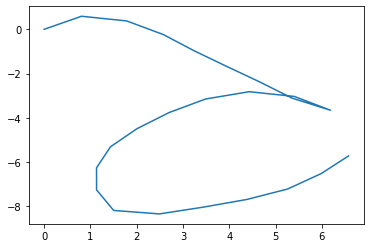

In [4]:
# il s'agit d'un 'a'
tracerLettre(X[0])
print(Y[0]) # vérification de l'étiquette

## A. Apprentissage d'un modèle CM (max de vraisemblance)
### A1. Discrétisation

**1 état = 1 angle**

Il est nécessaire de regrouper les angles en un nombre fini d'états (par exemple 20)
- définir un `intervalle = 360 / n_etats` (18° si on choisit 20 états)
- discrétiser tous les signaux à l'aide de la formule `np.floor(x / intervalle)`
    - si n_etats = 20 alors [0, 18[ => 0, [18, 36[ => 1, etc...

Donner le code de la méthode `discretise(x, d)` qui prend la base des signaux et retourne une base de signaux discrétisés.

In [5]:
def discretise(x, d):
    
    # Votre code :
    intervalle = 360 / d
    
    return np.array([np.floor(x[i]/intervalle) for i in range(x.shape[0])], dtype=object)

discretise(X, 3)[0]

array([0., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
       2., 0., 0., 0., 0., 0.])

**VALIDATION :** code du premier signal avec une discrétisation sur 3 états:
```python
array([ 0.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,  1., 1., 1., 2., 2.,  2.,
       2.,  0.,  0.,  0.,  0.,  0.])
```

### A2. Regrouper les indices des signaux par classe (pour faciliter l'apprentissage)

In [6]:
def groupByLabel(y):
    index = []
    for i in np.unique(y): # pour toutes les classes
        ind, = np.where(y == i)
        index.append(ind)
    return index

Y_c = groupByLabel(Y)
# np.unique(Y,return_counts=True)

In [9]:
Y_c[:6]

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]),
 array([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 array([44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]),
 array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65])]

Cette méthode produit simplement une structure type:
```python
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]),
 array([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 array([44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]),
 array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]),
 ...
```
Chaque ligne regroupe les indices de signaux correspondant à une classe. Il y a donc 11 exemples de 'a'.

### A3. Apprendre les modèles CM

Soit {$X_C$} la base de signaux discrétisés correspondant à une classe {$C$} et {$d$} le nombre d'états. Donner le code de la fonction `learnMarkovModel(Xc, d)` qui retourne un tuple contenant Pi et A.

Rappel:
- Initialisation de 
```python
 A = np.zeros((d, d))
 Pi = np.zeros(d)```
- Parcours de tous les signaux et incréments de A et Pi
- Normalisation (un peu réfléchie pour éviter les divisions par 0)
```python
A = A / np.maximum(A.sum(1).reshape(d, 1), 1) # normalisation
Pi = Pi / Pi.sum()```

**Note** : la solution proposée pour gérer le cas des lignes entièrement à 0 est naïve et n'est pas totalement satisfaisante. Comprendre pourquoi. On proposera une solution améliorée plus loin dans le TME. 

In [74]:
def learnMarkovModel(Xc, d):
    
    # votre code
    A = np.zeros((d,d))
    Pi = np.zeros(d)
    
    for i in range(len(Xc)):
        Xi = Xc[i]
        Pi[int(Xi[0])] += 1
        for j in range(1,len(Xi)):
            A[int(Xi[j-1]),int(Xi[j])] += 1
    
    A = A / np.maximum(A.sum(1).reshape(d,1), 1)    # normalisation
    Pi = Pi / Pi.sum()
    
    return Pi, A

In [11]:
d = 3
Y_c_a = Y_c[0]
Xa = discretise(X[Y_c_a], d)

Pi, A = learnMarkovModel(Xa, d)
print(Pi,"\n",A)

[0.36363636 0.         0.63636364] 
 [[0.84444444 0.06666667 0.08888889]
 [0.         0.83333333 0.16666667]
 [0.11382114 0.06504065 0.82113821]]


**Validation :** premier modèle avec une discrétisation sur 3 états :
```python
(array([ 0.36363636,  0.        ,  0.63636364]),
 array([[ 0.84444444,  0.06666667,  0.08888889],
       [ 0.        ,  0.83333333,  0.16666667],
       [ 0.11382114,  0.06504065,  0.82113821]]))
```

### A4. Stocker les modèles dans une liste

Pour un usage ultérieur plus facile, on utilise le code suivant :

In [12]:
d = 20                   # paramètre de discrétisation
Xd = discretise(X, d)    # application de la discrétisation
index = groupByLabel(Y)  # groupement des signaux par classe
models = []
for cl in range(len(np.unique(Y))): # parcours de toutes les classes et optimisation des modèles
    models.append(learnMarkovModel(Xd[index[cl]], d))

In [13]:
d_3 = 3                   # paramètre de discrétisation
Xd_3 = discretise(X, d_3)    # application de la discrétisation
models_3 = []
for cl in range(len(np.unique(Y))): # parcours de toutes les classes et optimisation des modèles
    models_3.append(learnMarkovModel(Xd_3[index[cl]], d_3))

### A5. Distribution stationnaire

La distribution stationnaire $\mu$, pour un système ergodique, correspond à:

- la distribution des états observés dans l'ensemble des données
- la distribution obtenu après un grand nombre de passage dans $A$ à partir de n'importe quelle distribution ou état d'origine (une matrice de transition ergodique va nous permettre de converger)
- la solution de l'équation de stabilité: $\mu = \mu A$

Dans le cas de la lettre 'a' et d'une discrétisation en 3 états, calculer la distribution stationnaire par les deux première méthode et vérifier que vous obtenez des résultats similaires.

**Note 1:** pour la marche aléatoire, vous construirez une boucle sur 100 iérations (borne sup) et vous sortirez dès que la somme des écarts (en absolu) entre $\mu_t$ et $\mu_{t+1}$ est inférieure à $10^{-3}$. Vous vérifierez ensuite que le système converge quelque soit l'état de départ (3 appel àla fonction) ou avec une initialisation aléatoire.

**Note 2:** les deux approches, bien que reposant sur les mêmes données, vont donner des solutions différentes. En effet, il n'y a que peu d'observations et le premier calcul repose sur les états alors que le second repose sur les transitions. 
Afin de vérifier l'exactitude de votre code, vous pourrez revenir sur cette question en fin de sujet avec le protocole suivant:
1. utiliser la matrice de transition de 'a' pour générer une séquence de longeur 100000
1. faire les statistiques des états (à l'aide d'un ```Counter``` par exemple)
1. vérifier la convergence sur de longues séquences

In [22]:
# Premiere approche
Pi, A = models_3[0]
iter_max = 100
mu = np.random.uniform(0,10,d_3)
mu = mu / np.maximum(mu.sum(), 1)

mu1 = mu
for it in range(iter_max):
  mu2 = mu1@A
  if np.abs(mu2-mu1).max() < 1e-3:
    break
  mu1 = mu2

print(mu2)

[0.2999502  0.28425166 0.41579814]


In [25]:
# Deuxieme approche

A1 = A
for it in range(iter_max):
  A2 = A1@A
  if np.abs(A2-A1).max() < 1e-3:
    break
  A1 = A2

mu3 = mu@A2
print(mu3)

[0.30155726 0.28346475 0.41497798]


In [27]:
# sequence de 100000
N = 100_000
# S = [np.random.choice([0,1,2],p=Pi)]
S0 = [0]
S1 = [1]
S2 = [2]
for i in range(1,N):
  S0.append(np.random.choice([j for j in range(d_3)],p=A[S0[-1]]))
  S1.append(np.random.choice([j for j in range(d_3)],p=A[S1[-1]]))
  S2.append(np.random.choice([j for j in range(d_3)],p=A[S2[-1]]))

print("Début avec 0",np.unique(S0[-100:],return_counts=True))
print("Début avec 1",np.unique(S1[-100:],return_counts=True))
print("Début avec 2",np.unique(S2[-100:],return_counts=True))

Début avec 0 (array([0, 1, 2]), array([41, 14, 45]))
Début avec 1 (array([0, 1, 2]), array([50, 14, 36]))
Début avec 2 (array([0, 1, 2]), array([12, 43, 45]))


In [29]:
# sequence de 100000
N = 1_000_000
S0 = [0]
S1 = [1]
S2 = [2]
for i in range(1,N):
  S0.append(np.random.choice([j for j in range(d_3 )],p=A[S0[-1]]))
  S1.append(np.random.choice([j for j in range(d_3 )],p=A[S1[-1]]))
  S2.append(np.random.choice([j for j in range(d_3 )],p=A[S2[-1]]))

print("Début avec 0",np.unique(S0[-100:],return_counts=True))
print("Début avec 1",np.unique(S1[-100:],return_counts=True))
print("Début avec 2",np.unique(S2[-100:],return_counts=True))

Début avec 0 (array([0, 1, 2]), array([20, 50, 30]))
Début avec 1 (array([0, 1, 2]), array([25, 21, 54]))
Début avec 2 (array([0, 1, 2]), array([37, 32, 31]))


##  B. Test (affectation dans les classes sur critère MV)
### B1. (log)Probabilité d'une séquence dans un modèle

Donner le code de la méthode `probaSequence(s,Pi,A)` qui retourne la log-probabilité d'une séquence `s` dans le modèle {$\lambda=\{Pi,A\}$} 

In [38]:
def probaSequence(S, Pi, A):
    
    # Votre code
    mu = Pi.copy()
    l = np.log(Pi[int(S[0])])
    s0 = S[0]
    
    for s in S[1:]:
        l += np.log(A[int(s0),int(s)])
        s0 = s
    
    return l

In [39]:
np.array([probaSequence(Xd_3[0],models_3[cl][0],models_3[cl][1]) for cl in range(len(np.unique(Y)))])

/var/folders/x7/bmqxr1zd3lxd_kcxxw9physr0000gn/T/ipykernel_27620/3874321713.py:5: RuntimeWarning: divide by zero encountered in log
  l = np.log(Pi[int(S[0])])
/var/folders/x7/bmqxr1zd3lxd_kcxxw9physr0000gn/T/ipykernel_27620/3874321713.py:9: RuntimeWarning: divide by zero encountered in log
  l += np.log(A[int(s0),int(s)])


array([-13.491086  ,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf, -12.48285678])

**VALIDATION :** probabilité du premier signal dans les 26 modèles avec une discrétisation sur 3 états :
```python
array([-13.491086  ,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf, -12.48285678])
```

- Ce signal est-il bien classé ?
- D'où viennent tous les `-inf` ? 

Ce signal n'est pas bien classé parceque le maximum de la log vraisemblance est sur '
z' alors que le signal représente plutôt le caractère 'a'.
Les -inf représentent la valeur du log en zéro. La probabilité que le signal soit un caractère entre 'b' et 'y' est quasi nulle.

### B2. Application de la méthode précédente pour tous les signaux et tous les modèles de lettres

L'application se fait en une ligne de code si vous avez respecté les spécifications précédentes : 

In [40]:
proba = np.array([[probaSequence(Xd[i], models[cl][0], models[cl][1]) for i in range(len(Xd))]
                  for cl in range(len(np.unique(Y)))])

/var/folders/x7/bmqxr1zd3lxd_kcxxw9physr0000gn/T/ipykernel_27620/3874321713.py:5: RuntimeWarning: divide by zero encountered in log
  l = np.log(Pi[int(S[0])])
/var/folders/x7/bmqxr1zd3lxd_kcxxw9physr0000gn/T/ipykernel_27620/3874321713.py:9: RuntimeWarning: divide by zero encountered in log
  l += np.log(A[int(s0),int(s)])


In [41]:
proba_3 = np.array([[probaSequence(Xd_3[i], models_3[cl][0], models_3[cl][1]) for i in range(len(Xd))]
                  for cl in range(len(np.unique(Y)))])

/var/folders/x7/bmqxr1zd3lxd_kcxxw9physr0000gn/T/ipykernel_27620/3874321713.py:5: RuntimeWarning: divide by zero encountered in log
  l = np.log(Pi[int(S[0])])
/var/folders/x7/bmqxr1zd3lxd_kcxxw9physr0000gn/T/ipykernel_27620/3874321713.py:9: RuntimeWarning: divide by zero encountered in log
  l += np.log(A[int(s0),int(s)])


### B3. Evaluation des performances

Pour l'évaluation, nous proposons l'approche suivante: 

In [44]:
# calcul d'une version numérique des Y :
Ynum = np.zeros(Y.shape)
for num, char in enumerate(np.unique(Y)):
    Ynum[Y == char] = num
    
# Calcul de la classe la plus probable :
pred = proba.argmax(0) # max colonne par colonne
pred_3 = proba_3.argmax(0) # max colonne par colonne

# Calcul d'un pourcentage de bonne classification :
per = np.where(pred != Ynum, 0.,1.).mean()
per_3 = np.where(pred_3 != Ynum, 0.,1.).mean()

In [45]:
print("Performance avec 20 états",per)
print("Performance avec 3 états",per_3)

Performance avec 20 états 0.914179104477612
Performance avec 3 états 0.6902985074626866


**INDICE DE PERFORMANCE :** 91% de bonne classification avec 20 états, 69% avec 3 états

## C. Biais d'évaluation, notion de sur-apprentissage

Dans le protocole précédent, nous avons triché:
- les données servent d'abord à apprendre les modèles...
- puis nous nous servons des mêmes données pour tester les modèles ! Les performances sont forcément bonnes ! 

Afin de palier le problème, nous allons diviser en deux la base de données: une partie servira à l'apprentissage des modèles, l'autre à leur évaluation. Pour effectuer la division, nous fournissons le code suivant: 

In [46]:
# separation app/test, pc=ratio de points en apprentissage
def separeTrainTest(y, pc):
    indTrain = []
    indTest = []
    for i in np.unique(y): # pour toutes les classes
        ind, = np.where(y == i)
        n = len(ind)
        indTrain.append(ind[np.random.permutation(n)][:int(np.floor(pc * n))])
        indTest.append(np.setdiff1d(ind, indTrain[-1]))
    return indTrain, indTest

# exemple d'utilisation
itrain, itest = separeTrainTest(Y, 0.8)

dans `itrain`, nous obtenons les indices des signaux qui doivent servir en apprentissage pour chaque classe :

In [48]:
itrain[:6]

[array([ 6,  0,  2,  4,  7,  8, 10,  5]),
 array([21, 17, 14, 20, 13, 12, 15, 16]),
 array([31, 29, 22, 32, 24, 23, 30, 28]),
 array([36, 39, 38, 40, 41, 42, 34, 33]),
 array([53, 44, 47, 54, 46, 49, 52, 50]),
 array([55, 56, 62, 59, 60, 61, 57, 58])]

**Note :** pour faciliter l'évaluation des modèles, vous aurez besoin de re-fusionner tous les indices d'apprentissage et de test. Cela se fait avec les lignes de code suivantes : 

In [49]:
ia = []
for i in itrain:
    ia += i.tolist()    
it = []
for i in itest:
    it += i.tolist()

**Note 2 :** Du fait de la permutation aléatoire, les résultats vont bouger (un peu) à chaque execution du programme. 

In [ ]:
d = 20                   # paramètre de discrétisation
Xd_a = discretise(X[ia], d)    # application de la discrétisation
index = groupByLabel(Y)  # groupement des signaux par classe
models_a = []
for cl in range(len(np.unique(Y))): # parcours de toutes les classes et optimisation des modèles
    models_a.append(learnMarkovModel(Xd_a[index[cl]], d))

### C1. Questions importantes
- Ré-utiliser les fonctions précédemment définies pour apprendre des modèles et les évaluer sans biais.
- Calculer et analyser les résultats obtenus en apprentissage et en test
- Etudier l'évolution des performances en fonction de la discrétisation

In [70]:
# Votre code
d = 20                   # paramètre de discrétisation
Xd_a,Xd_t = discretise(X[ia], d), discretise(X[it], d)
Y_a,Y_t = Y[ia],Y[it]

index = groupByLabel(Y_a)  # groupement des signaux par classe
models_a = []
for cl in range(len(np.unique(Y_a))): # parcours de toutes les classes et optimisation des modèles
    models_a.append(learnMarkovModel(Xd_a[index[cl]], d))

d_3 = 3                   # paramètre de discrétisation
Xd_3_a,Xd_3_t = discretise(X[ia], d_3),discretise(X[it], d_3)    # application de la discrétisation
models_3_a = []
for cl in range(len(np.unique(Y_a))): # parcours de toutes les classes et optimisation des modèles
    models_3_a.append(learnMarkovModel(Xd_3_a[index[cl]], d_3))

In [71]:
proba_a = np.array([[probaSequence(Xd_a[i], models_a[cl][0], models_a[cl][1]) for i in range(len(Xd_a))]
                  for cl in range(len(np.unique(Y_a)))])
proba_t = np.array([[probaSequence(Xd_t[i], models_a[cl][0], models_a[cl][1]) for i in range(len(Xd_t))]
                  for cl in range(len(np.unique(Y_t)))])

# avec 3 états
proba_a_3 = np.array([[probaSequence(Xd_3_a[i], models_3_a[cl][0], models_3_a[cl][1]) for i in range(len(Xd_3_a))]
                 for cl in range(len(np.unique(Y_a)))])
proba_t_3 = np.array([[probaSequence(Xd_3_t[i], models_3_a[cl][0], models_3_a[cl][1]) for i in range(len(Xd_3_t))]
                 for cl in range(len(np.unique(Y_a)))])

# perfs
# calcul d'une version numérique des Y :
Ynum_a = np.zeros(Y_a.shape)
for num, char in enumerate(np.unique(Y_a)):
    Ynum_a[Y_a == char] = num
Ynum_t = np.zeros(Y_t.shape)
for num, char in enumerate(np.unique(Y_t)):
    Ynum_t[Y_t == char] = num
    
# Calcul de la classe la plus probable :
pred_a,pred_t = proba_a.argmax(0),proba_t.argmax(0) # max colonne par colonne
pred_a_3,pred_t_3 = proba_a_3.argmax(0),proba_t_3.argmax(0) # max colonne par colonne

# Calcul d'un pourcentage de bonne classification :
per_a,per_t = np.where(pred_a != Ynum_a, 0.,1.).mean(),np.where(pred_t != Ynum_t, 0.,1.).mean()
per_a_3,per_t_3 = np.where(pred_a_3 != Ynum_a, 0.,1.).mean(),np.where(pred_t_3 != Ynum_t, 0.,1.).mean()

print("Performance sur les données d'apprentissage avec 20 états:",per_a)
print("Performance sur les données de test avec 20 états:",per_t)

print("Performance sur les données d'apprentissage avec 3 états:",per_a_3)
print("Performance sur les données de test avec 3 états:",per_t_3)

/var/folders/x7/bmqxr1zd3lxd_kcxxw9physr0000gn/T/ipykernel_27620/3874321713.py:5: RuntimeWarning: divide by zero encountered in log
  l = np.log(Pi[int(S[0])])
/var/folders/x7/bmqxr1zd3lxd_kcxxw9physr0000gn/T/ipykernel_27620/3874321713.py:9: RuntimeWarning: divide by zero encountered in log
  l += np.log(A[int(s0),int(s)])


Performance sur les données d'apprentissage avec 20 états: 0.9326923076923077
Performance sur les données de test avec 20 états: 0.21666666666666667
Performance sur les données d'apprentissage avec 3 états: 0.6682692307692307
Performance sur les données de test avec 3 états: 0.6166666666666667


### C2. Lutter contre le sur-apprentissage
Cette base de données met en lumière le phénomène de sur-apprentissage : il y a peu de données et dès que le nombre d'états augmente, il y a trop peu d'exemple pour estimer correctement les matrices {$A, \pi$}. De nombreuses cases sont donc à 0, voire des lignes entières (d'où la sécurisation du code pour la normalisation des matrices stochastiques).

Ces 0 sont particulièrement discriminants: considérant la classe {$c$}, ils permettent d'éliminer de cette classe tout signal présentant cette caractéristique. Cette règle est trop forte compte tenu de la taille de la base d'apprentissage. Nous proposons une astuce pour palier cette faiblesse : lors du comptage, initialiser les matrices {$A, \pi$} avec ones au lieu de zeros . On fait semblant d'avoir observer une transition de chaque type avant même le début du comptage.

Comparer les performances en test.

In [75]:
def learnMarkovModel(Xc, d):
    
    # votre code
    A = np.ones((d,d))
    Pi = np.ones(d)
    
    for i in range(len(Xc)):
        Xi = Xc[i]
        Pi[int(Xi[0])] += 1
        for j in range(1,len(Xi)):
            A[int(Xi[j-1]),int(Xi[j])] += 1
    
    A = A / np.maximum(A.sum(1).reshape(d,1), 1)    # normalisation
    Pi = Pi / Pi.sum()
    
    return Pi, A

In [76]:
# Votre code
d = 20                   # paramètre de discrétisation
Xd_a,Xd_t = discretise(X[ia], d), discretise(X[it], d)
Y_a,Y_t = Y[ia],Y[it]

index = groupByLabel(Y_a)  # groupement des signaux par classe
models_a = []
for cl in range(len(np.unique(Y_a))): # parcours de toutes les classes et optimisation des modèles
    models_a.append(learnMarkovModel(Xd_a[index[cl]], d))

d_3 = 3                   # paramètre de discrétisation
Xd_3_a,Xd_3_t = discretise(X[ia], d_3),discretise(X[it], d_3)    # application de la discrétisation
models_3_a = []
for cl in range(len(np.unique(Y_a))): # parcours de toutes les classes et optimisation des modèles
    models_3_a.append(learnMarkovModel(Xd_3_a[index[cl]], d_3))


# comparaison en test
proba_t = np.array([[probaSequence(Xd_t[i], models_a[cl][0], models_a[cl][1]) for i in range(len(Xd_t))]
                  for cl in range(len(np.unique(Y_t)))])

# avec 3 états
proba_t_3 = np.array([[probaSequence(Xd_3_t[i], models_3_a[cl][0], models_3_a[cl][1]) for i in range(len(Xd_3_t))]
                 for cl in range(len(np.unique(Y_a)))])

# perfs
# calcul d'une version numérique des Y :
Ynum_t = np.zeros(Y_t.shape)
for num, char in enumerate(np.unique(Y_t)):
    Ynum_t[Y_t == char] = num
    
# Calcul de la classe la plus probable :
pred_t = proba_t.argmax(0) # max colonne par colonne
pred_t_3 = proba_t_3.argmax(0) # max colonne par colonne

# Calcul d'un pourcentage de bonne classification :
per_t = np.where(pred_t != Ynum_t, 0.,1.).mean()
per_t_3 = np.where(pred_t_3 != Ynum_t, 0.,1.).mean()

print("Performance sur les données de test avec 20 états:",per_t)
print("Performance sur les données de test avec 3 états:",per_t_3)

Performance sur les données de test avec 20 états: 0.6666666666666666
Performance sur les données de test avec 3 états: 0.5166666666666667


La performance avec 20 états augmente, elle passe de 21% à 51%.

## D. Evaluation qualitative

Nous nous demandons maintenant où se trouvent les erreurs que nous avons commises...

Calcul de la matrice de confusion: pour chaque échantillon de test, nous avons une prédiction (issue du modèle) et une vérité terrain (la vraie étiquette). En posant Nc le nombre de classes, la matrice de confusion est une matrice (Nc x Nc) où nous comptons le nombre d'échantillon de test dans chaque catégorie :

- Initialisation à 0 : 

In [77]:
conf = np.zeros((26,26))

- Pour chaque échantillon, incrément de la case (prediction, vérité)

In [82]:
Ynum_t

array([ 0.,  0.,  0.,  1.,  1.,  1.,  2.,  2.,  2.,  3.,  3.,  3.,  4.,
        4.,  4.,  5.,  5.,  5.,  6.,  6.,  6.,  7.,  7.,  7.,  8.,  8.,
        9.,  9., 10., 10., 11., 11., 12., 12., 13., 13., 14., 14., 15.,
       15., 16., 16., 17., 17., 18., 18., 19., 19., 20., 20., 21., 21.,
       22., 22., 23., 23., 24., 24., 25., 25.])

In [83]:
# Votre code
for i in range(pred_t.shape[0]):
  conf[pred_t[i],int(Ynum_t[i])] += 1

- Tracé de la matrice : 

Text(0, 0.5, 'Prédiction')

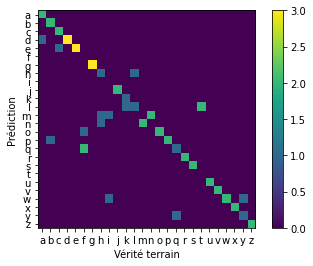

In [84]:
plt.figure()
plt.imshow(conf, interpolation = 'nearest')
plt.colorbar()
plt.xticks(np.arange(26), np.unique(Y))
plt.yticks(np.arange(26), np.unique(Y))
plt.xlabel(u'Vérité terrain')
plt.ylabel(u'Prédiction')
#plt.savefig("mat_conf_lettres.png")

## E. Modèle génératif

Utiliser les modèles appris pour générer de nouvelles lettres manuscrites.

### E1. Tirage selon une loi de probabilité discrète

- faire la somme cumulée de la loi {$sc$}
- tirer un nombre aléatoire {$t$} entre 0 et 1
- trouver la première valeur de {$sc$} qui est supérieure à {$t$}
- retourner cet état 

**Note :** comme vu en cours, tout repose sur la somme cumulée (notée ici `sc$`, calculable en appelant `np.cumsum`. Sur un exemple: la loi `V = [0.2, 0.4, 0.3, 0.1]` a pour somme cumulée `V.cumsum() == [0.2,  0.6,  0.9,  1.0]`

### E2. Génération d'une séquence de longueur N

- tirer un état {$s_0$} selon Pi
- tant que la longueur n'est pas atteinte :
  - tirer un état {$s_{t+1}$} selon {$A[s_{t}]$} 

In [85]:
A

array([[0.84444444, 0.06666667, 0.08888889],
       [0.        , 0.83333333, 0.16666667],
       [0.11382114, 0.06504065, 0.82113821]])

In [90]:
# Votre code
def generate(Pi,A,N):
  Picum,Acum = Pi.cumsum(),A.cumsum(1)
  r = np.random.rand()
  s = []
  for e in range(A.shape[1]):
    if r<Picum[e]:
      s = [e]
      break
  
  for i in range(1,N):
    r = np.random.rand()
    for e in range(A.shape[1]):
      if r<Acum[s[-1],e]:
        s.append(e)
        break
  
  return s

### E3. Affichage du résultat

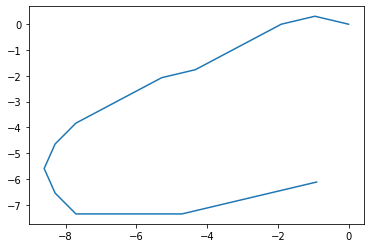

In [96]:
c = 2
newa = generate(models[c][0], models[c][1], 20)       # generation d'une séquence d'états
intervalle = 360. / d                                 # pour passer des états => valeur d'angles
newa_continu = np.array([i * intervalle for i in newa]) # conv int => double
tracerLettre(newa_continu)